#### **O que precisa ser feito?**
Seu objetivo é trazer as principais métricas relacionadas à aquisição de clínicas uma análise de dados exploratória com essa base, de forma a identificar gargalos e oportunidades para otimizar a entrada de clinicas na Real.

In [2]:
# Importando as bibliotecas Python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
import library as lib

import warnings
warnings.filterwarnings('ignore')

In [3]:
import importlib
importlib.reload(lib)

<module 'library' from 'd:\\repositorio\\datascience\\case\\aquisicao_clinicas\\aquisicao_clinicas\\library.py'>

In [4]:
lib.colormap = 'mako_r'

In [5]:
# Lendo os dados de um arquivo .csv
df_real = pd.read_csv(r'..\dados\aquisicao_clinicas_completo.csv',
                       parse_dates=['ACTIVITY_AT','CLINIC_CREATED_AT','TRIAL_START_DATE','TRIAL_END_DATE','SUBSCRIPTION_START_DATE','SUBSCRIPTION_END_DATE'])
df_real.head()

,CLINIC_ID,ACTIVITY_AT,ACTIVITY_TYPE,FEATURE,MODULE,IS_VALID_ACTIVITY,CLINIC_CREATED_AT,IS_CHAIN_CLINIC,FIRST_USER_HUBSPOT_SOURCE,INTEREST_CATEGORY_SIGNUP,...,IS_ACCREDITATION_APPROVED,IS_ACCREDITATION_REPROVED,CLINIC_ACCREDITATION_STATUS,STRIPE_SUBSCRIPTION_ID,SUBSCRIPTION_START_DATE,SUBSCRIPTION_END_DATE,SUBSCRIPTION_PERIOD_DAYS,SUBSCRIPTION_PERIOD,SUBSCRIPTION_STATUS,BILLING_INTERVAL_IN_MONTHS
0,9825,2023-08-24 18:46:47.733,patient_discarded,patient_management,patient,True,2023-08-21 09:14:34.763,False,Inbound,Apenas BNPL,...,True,False,Concluído,sub_1Nj29VCpjOdJI4gTsWNO1Kzm,2023-08-25,2023-10-25,61.0,Entre 61 e 90 dias,active,1.0
1,9984,2023-08-24 19:41:43.497,patient_created,patient_management,patient,False,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,True,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN
2,9984,2023-08-24 19:41:44.037,time_slot_created,scheduling,schedule,True,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,True,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN
3,9984,2023-08-24 19:51:20.451,patient_created,patient_management,patient,False,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,True,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4,9984,2023-08-24 19:51:46.663,time_slot_created,scheduling,schedule,True,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,True,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [6]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12421 entries, 0 to 12420
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   CLINIC_ID                             12421 non-null  int64         
 1   ACTIVITY_AT                           12421 non-null  datetime64[ns]
 2   ACTIVITY_TYPE                         12421 non-null  object        
 3   FEATURE                               12421 non-null  object        
 4   MODULE                                12421 non-null  object        
 5   IS_VALID_ACTIVITY                     12421 non-null  bool          
 6   CLINIC_CREATED_AT                     12421 non-null  datetime64[ns]
 7   IS_CHAIN_CLINIC                       12421 non-null  bool          
 8   FIRST_USER_HUBSPOT_SOURCE             12421 non-null  object        
 9   INTEREST_CATEGORY_SIGNUP              12421 non-null  object        
 10

#### Abaixo, estão as métricas que iremos explorar em nosso projeto

* Duração Média do Trial
    * Indicador: Duração média do período de trial (em dias) para todas as clínicas.
    * Indicador: Distribuição da duração do trial (quantas clínicas terminaram o trial em 7 dias, 14 dias, etc.).
    * Por que é importante?: Ajuda a entender se o período de trial oferecido é suficiente para as clínicas explorarem todas as funcionalidades e tomarem uma decisão informada.
    
* Atividades por Clínica
    * Indicador: Número médio de atividades realizadas por clínica durante o trial.
    * Indicador: Distribuição do número de atividades por clínica (quantas clínicas realizaram mais de X atividades).
    * Por que é importante?: Um número maior de atividades pode indicar um maior envolvimento e engajamento com o produto, aumentando a probabilidade de conversão para uma assinatura paga.  

* Distribuição de Atividades
    * Indicador: Frequência dos diferentes tipos de atividades realizadas (uso de agenda, prontuário eletrônico, gestão financeira, etc.). Quais funcionalidades são mais usadas durante o trial. 
    * Por que é importante?: Entender quais funcionalidades estão sendo mais utilizadas pode indicar quais aspectos do produto são mais valiosos para os usuários durante o trial.     

* Engajamento Funcional
    * Indicador: Análise detalhada de engajamento em funcionalidades específicas (e.g., quantas clínicas usam a agenda e com que frequência).
    * Por que é importante?: Funcionalidades que têm uma alta taxa de uso durante o trial são boas candidatas para promoção em campanhas de marketing ou foco de melhorias. Também ajuda a identificar funcionalidades que podem precisar de maior visibilidade ou refinamento.

* Taxa de Conversão Pós-Trial
    * Indicador: Percentual de clínicas que convertem para assinaturas pagas após o trial.
    * Por que é importante?: A taxa de conversão é o principal indicador de sucesso do período de trial. Ela revela a eficácia do trial em demonstrar o valor do produto.
    
* Número de atividades realizadas
    * Indicador: Comparação de conversão entre clínicas que realizaram um número alto de atividades versus um número baixo.
    * Por que é importante?: É fundamental para entender melhor o comportamento dos clientes, identificar padrões de sucesso e otimizar as estratégias de engajamento e conversão.

* Atividades de Alto Impacto:
    * Indicador: Identificação de atividades que têm maior correlação com a conversão (e.g., clínicas que usam a gestão financeira têm maior chance de converter).    
    * Por que é importante?: Permite uma abordagem mais direcionada, tanto no onboarding quanto em marketing, vendas e desenvolvimento de produto. Isso aumenta a eficiência das estratégias de aquisição e retenção, além de melhorar a experiência do cliente ao destacar funcionalidades que realmente agregam valor.

* Taxa de Solicitação de Credenciamento
    * Indicador: Percentual de clínicas que solicitam credenciamento durante o trial.
    * Por que é importante?: Credenciamento é um passo importante para o uso do Financiamento Real (BNPL). Este indicador pode revelar o interesse em uma das funcionalidades mais diferenciadas do produto.
    
* Conversão de clínicas credenciadas versus não credenciadas.    
    * Indicador: Comparação da taxa de conversão entre clínicas credenciadas versus não credenciadas.
    * Por que é importante?: Entender o impacto do credenciamento ou não, pode ofercer insights profundos sobre engajamento, validação de estratégias de marketing, retorno sobre investimento em credenciamento e melhorias no processo de onboarding. 

* Identificação dos Canais Mais Eficazes
    * Indicador: Percentual de comparação de performance de conversão entre diferentes fontes de canal de marketing.
    * Por que é importante?: Diferentes canais de marketing atraem diferentes tipos de clientes, e alguns canais podem ser mais eficazes em converter leads em clientes pagantes do que outros. Analisar a taxa de conversão por canal ajuda a identificar quais canais trazem leads qualificados que têm maior probabilidade de se tornarem clientes pagantes.

* Pontos de Desistência (Churn)
    * Indicador: Percentual de clínicas que param de usar o produto durante o trial (não realizaram a assinatura do produto).
    * Indicador: Percentual de clínicas que param de usar o produto após o trial (realizaram a assinatura do produto, porém ela não esta mais ativa).
    * Por que é importante?: Identificar onde as clínicas perdem interesse pode indicar problemas na usabilidade, falta de valor percebido, ou outros fatores que podem ser corrigidos. 

In [7]:
# Cria um dataframe contendo registros unicos por clinica
clinicas_unicas_periodo_trial = df_real.drop_duplicates(subset=['CLINIC_ID'])
clinicas_unicas_periodo_trial

,CLINIC_ID,ACTIVITY_AT,ACTIVITY_TYPE,FEATURE,MODULE,IS_VALID_ACTIVITY,CLINIC_CREATED_AT,IS_CHAIN_CLINIC,FIRST_USER_HUBSPOT_SOURCE,INTEREST_CATEGORY_SIGNUP,...,IS_ACCREDITATION_APPROVED,IS_ACCREDITATION_REPROVED,CLINIC_ACCREDITATION_STATUS,STRIPE_SUBSCRIPTION_ID,SUBSCRIPTION_START_DATE,SUBSCRIPTION_END_DATE,SUBSCRIPTION_PERIOD_DAYS,SUBSCRIPTION_PERIOD,SUBSCRIPTION_STATUS,BILLING_INTERVAL_IN_MONTHS
0,9825,2023-08-24 18:46:47.733,patient_discarded,patient_management,patient,True,2023-08-21 09:14:34.763,False,Inbound,Apenas BNPL,...,True,False,Concluído,sub_1Nj29VCpjOdJI4gTsWNO1Kzm,2023-08-25,2023-10-25,61.0,Entre 61 e 90 dias,active,1.0
1,9984,2023-08-24 19:41:43.497,patient_created,patient_management,patient,False,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,True,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN
5,9986,2023-08-24 20:32:47.128,patient_created,patient_management,patient,False,2023-08-24 20:31:43.062,False,Inbound,BNPL e SaaS,...,True,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN
7,9988,2023-08-24 22:06:04.848,patient_created,patient_management,patient,False,2023-08-24 22:04:10.022,False,Inbound,Apenas SaaS,...,False,False,Não aderiu ao plano,NaN,NaT,NaT,NaN,NaN,NaN,NaN
9,9690,2023-08-24 22:07:59.840,patient_created,patient_management,patient,False,2023-08-17 04:33:00.786,False,Inbound,Apenas BNPL,...,False,False,Não aderiu ao plano,NaN,NaT,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12393,9011,2023-10-09 18:16:08.793,pre_analysis,bnpl,finance,False,2023-08-01 13:01:05.019,False,Inbound,Apenas BNPL,...,True,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN
12395,11180,2023-10-10 17:42:02.047,pre_analysis,bnpl,finance,False,2023-09-27 14:01:04.040,False,Inbound,Apenas BNPL,...,True,False,Concluído,sub_1NzmetCpjOdJI4gTROeKTccm,2023-10-10,NaT,999.0,Período em aberto,active,1.0
12397,11146,2023-10-16 19:56:48.050,pre_analysis,bnpl,finance,False,2023-09-26 19:21:15.702,False,Inbound,Apenas BNPL,...,True,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN
12399,10314,2023-10-17 21:30:57.007,patient_created,patient_management,patient,False,2023-09-05 01:05:51.799,False,Inbound,Apenas BNPL,...,True,False,Concluído,sub_1O2F0FCpjOdJI4gT1kqeULiV,2023-10-17,NaT,999.0,Período em aberto,active,1.0


* #### Métricas de Duração do Trial

In [8]:
# Duração média do período de trial para todas as clínicas.
media_duracao_trial = clinicas_unicas_periodo_trial['TRIAL_DURATION'].mean()
media_duracao_trial

8.611393692777213

In [182]:
# Distribuição da duração do trial.
clinicas_unicas_periodo_trial['TRIAL_DURATION'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
TRIAL_DURATION,983.0,8.611394,17.544345,0.0,7.0,7.0,7.0,365.0


* #### Métricas de Interação Durante o Trial

In [183]:
# Número médio de atividades realizadas por clínica durante o trial.
media_atividade_por_clinica = df_real.loc[df_real['IS_VALID_ACTIVITY']].groupby(by='CLINIC_ID').size().mean()
media_atividade_por_clinica


9.573598130841122

In [184]:
#  Distribuição do número de atividades por clínica (quantas clínicas realizaram mais de X atividades).
df_real.loc[df_real['IS_VALID_ACTIVITY']].groupby(by='CLINIC_ID').size().describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,856.0,9.573598,28.864624,1.0,1.0,3.0,8.0,599.0


In [135]:
#  Distribuição do número de atividades por clínica (quantas clínicas realizaram mais de X atividades).
distribuicao_atividades_por_clinica = df_real.loc[df_real['IS_VALID_ACTIVITY']].groupby(by='CLINIC_ID').size().sort_values(ascending=False).to_frame(name='frequência de atividades')
distribuicao_atividades_por_clinica

,frequência de atividades
CLINIC_ID,
10449,599
10138,264
11275,193
10915,175
9825,173
...,...
9959,1
9960,1
10640,1


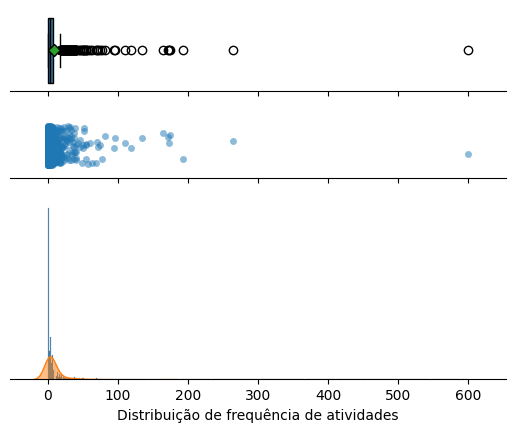

In [378]:
#  Distribuição do número de atividades por clínica (quantas clínicas realizaram mais de X atividades).
lib.plot_distribuicao(dataframe=distribuicao_atividades_por_clinica, coluna='frequência de atividades')

In [122]:
# Frequência dos diferentes tipos de atividades realizadas (uso de agenda, prontuário eletrônico, gestão financeira, etc.).
df_real.loc[df_real['IS_VALID_ACTIVITY'] == True]['ACTIVITY_TYPE'].agg(['value_counts'
                                                                        ,lambda x : (x.value_counts() / df_real.loc[df_real['IS_VALID_ACTIVITY'] == True].shape[0])*100]).rename(columns={'value_counts':'frequência', '<lambda>':'porcentagem'})

,frequência,porcentagem
ACTIVITY_TYPE,,
procedure_created,2516,30.533981
time_slot_created,2167,26.298544
budget_created,789,9.575243
revenue_created,466,5.655340
anamnesis_created,407,4.939320
expense_created,271,3.288835
time_slot_discarded,271,3.288835
procedure_discarded,257,3.118932
new_user_created,238,2.888350


In [379]:
# Quais funcionalidades são mais usadas durante o trial.   
lib.frequencia_cat(dataframe=df_real.loc[df_real['IS_VALID_ACTIVITY']], coluna='FEATURE')

,FEATURE,frequencia,porcentagem
10,payment_book,3,0.036608
9,bnpl,7,0.085418
8,credit_check,57,0.695546
7,user_management,207,2.525930
6,documents_and_files,232,2.830995
5,patient_management,327,3.990238
4,anamnese,444,5.417938
3,revenue_management,737,8.993289
2,budget_management,949,11.580232
1,scheduling,2459,30.006101


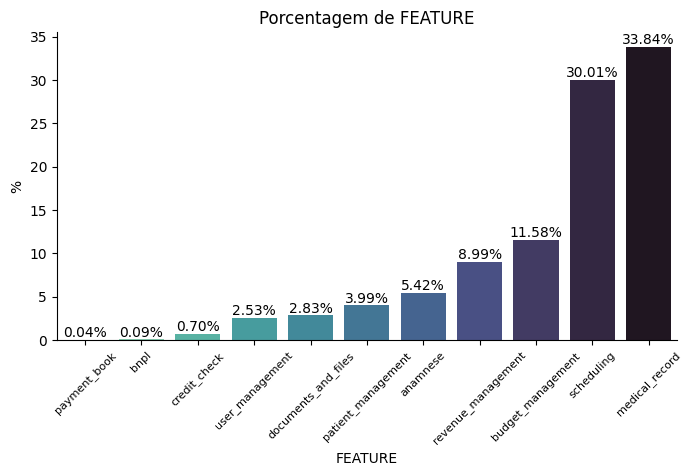

In [380]:
lib.plot_frequencia_cat(df_real.loc[df_real['IS_VALID_ACTIVITY']], coluna='FEATURE')

In [381]:
# Percentual de clínicas que utilizam funcionalidades específicas (como prontuário eletrônico, agenda, gestão financeira).
lib.frequencia_cat(dataframe=df_real.loc[(df_real['IS_VALID_ACTIVITY'])].drop_duplicates(subset=['FEATURE','CLINIC_ID']), coluna='FEATURE')

,FEATURE,frequencia,porcentagem
10,payment_book,2,0.086994
9,bnpl,7,0.304480
8,credit_check,30,1.304915
7,documents_and_files,115,5.002175
6,user_management,117,5.089169
5,patient_management,126,5.480644
4,revenue_management,208,9.047412
3,anamnese,283,12.309700
2,budget_management,294,12.788169
1,medical_record,393,17.094389


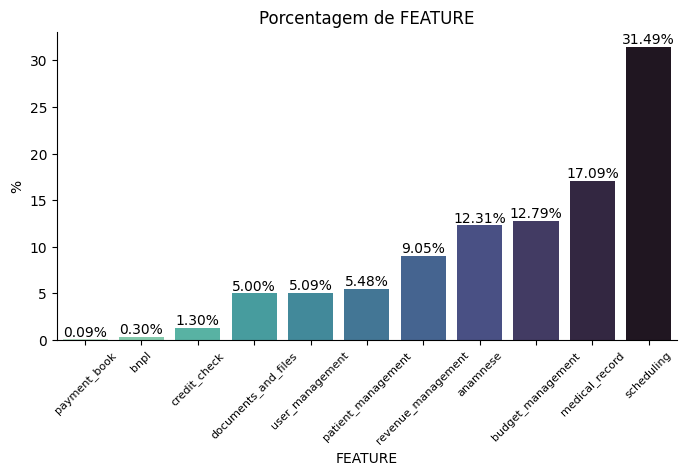

In [382]:
lib.plot_frequencia_cat(dataframe=df_real.loc[(df_real['IS_VALID_ACTIVITY'])].drop_duplicates(subset=['FEATURE','CLINIC_ID']), coluna='FEATURE')

* #### Métricas de Conversão no Trial

In [9]:
# Percentual de clínicas que convertem para assinaturas pagas após o trial. 
# A conversão requer um registro de assinatura onde STRIPE_SUBSCRIPTION_ID seja diferente de NaN, não importando o status.
clinicas_convertidas = df_real.loc[~df_real['STRIPE_SUBSCRIPTION_ID'].isna()].drop_duplicates(subset=['CLINIC_ID'])['CLINIC_ID']
num_clinicas_convertidas = clinicas_convertidas.size

percentual_clinicas_convertidas = (num_clinicas_convertidas / (clinicas_unicas_periodo_trial.shape[0])) * 100
percentual_clinicas_convertidas

27.46693794506612

In [10]:
# Clinica foi convertida? Fez a assinatura ou não.
df_real['CLINICA_CONVERTIDA'] =  np.where(df_real['CLINIC_ID'].isin(clinicas_convertidas), True, False)
df_real

,CLINIC_ID,ACTIVITY_AT,ACTIVITY_TYPE,FEATURE,MODULE,IS_VALID_ACTIVITY,CLINIC_CREATED_AT,IS_CHAIN_CLINIC,FIRST_USER_HUBSPOT_SOURCE,INTEREST_CATEGORY_SIGNUP,...,IS_ACCREDITATION_REPROVED,CLINIC_ACCREDITATION_STATUS,STRIPE_SUBSCRIPTION_ID,SUBSCRIPTION_START_DATE,SUBSCRIPTION_END_DATE,SUBSCRIPTION_PERIOD_DAYS,SUBSCRIPTION_PERIOD,SUBSCRIPTION_STATUS,BILLING_INTERVAL_IN_MONTHS,CLINICA_CONVERTIDA
0,9825,2023-08-24 18:46:47.733,patient_discarded,patient_management,patient,True,2023-08-21 09:14:34.763,False,Inbound,Apenas BNPL,...,False,Concluído,sub_1Nj29VCpjOdJI4gTsWNO1Kzm,2023-08-25,2023-10-25,61.0,Entre 61 e 90 dias,active,1.0,True
1,9984,2023-08-24 19:41:43.497,patient_created,patient_management,patient,False,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False
2,9984,2023-08-24 19:41:44.037,time_slot_created,scheduling,schedule,True,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False
3,9984,2023-08-24 19:51:20.451,patient_created,patient_management,patient,False,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False
4,9984,2023-08-24 19:51:46.663,time_slot_created,scheduling,schedule,True,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12416,11234,2023-10-19 14:29:27.826,revenue_created,revenue_management,finance,True,2023-09-28 16:27:41.579,False,Inbound,BNPL e SaaS,...,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False
12417,11234,2023-10-19 14:37:20.492,pre_analysis,bnpl,finance,False,2023-09-28 16:27:41.579,False,Inbound,BNPL e SaaS,...,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False
12418,11234,2023-10-19 14:53:48.231,pre_analysis,bnpl,finance,False,2023-09-28 16:27:41.579,False,Inbound,BNPL e SaaS,...,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False
12419,10254,2023-10-19 15:09:50.063,pre_analysis,bnpl,finance,False,2023-09-03 07:55:29.365,False,Inbound,BNPL e SaaS,...,False,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False


In [31]:
# Percentual de clínicas que convertem para assinaturas pagas após o trial. 
# A conversão requer um registro de assinatura onde STRIPE_SUBSCRIPTION_ID seja diferente de NaN, não importando o status.
lib.frequencia_cat(dataframe=df_real.drop_duplicates(subset=['CLINIC_ID']), coluna='CLINICA_CONVERTIDA')

,CLINICA_CONVERTIDA,frequencia,porcentagem
1,True,270,27.466938
0,False,713,72.533062


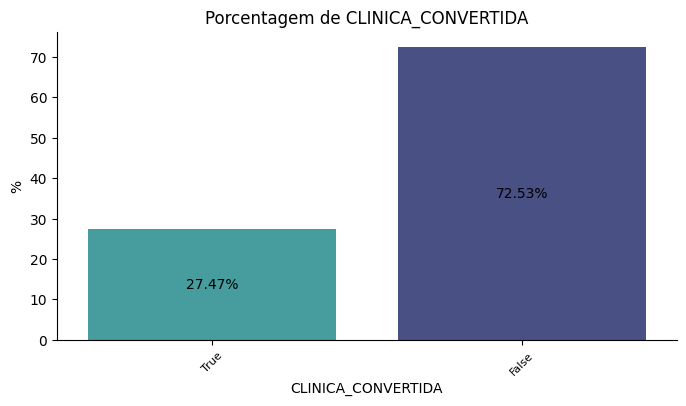

In [32]:
lib.plot_frequencia_cat(dataframe=df_real.drop_duplicates(subset=['CLINIC_ID']), coluna='CLINICA_CONVERTIDA')

In [205]:
# Tempo médio desde o início do trial até a conversão para assinatura paga.
tempo_medio_conversao = (df_real.loc[df_real['CLINICA_CONVERTIDA']].drop_duplicates(subset=['CLINIC_ID'])['SUBSCRIPTION_START_DATE'] - 
                         df_real.loc[df_real['CLINICA_CONVERTIDA']].drop_duplicates(subset=['CLINIC_ID'])['TRIAL_START_DATE']).dt.days.describe()
tempo_medio_conversao

count    270.000000
mean       9.311111
std       10.432981
min        0.000000
25%        2.000000
50%        7.000000
75%       12.000000
max       60.000000
dtype: float64

In [206]:
# Tempo médio desde o início do trial até a conversão para assinatura paga.
tempo_medio_conversao = (df_real.loc[df_real['CLINICA_CONVERTIDA']].drop_duplicates(subset=['CLINIC_ID'])['SUBSCRIPTION_START_DATE'] - 
                         df_real.loc[df_real['CLINICA_CONVERTIDA']].drop_duplicates(subset=['CLINIC_ID'])['TRIAL_START_DATE']).dt.days.mean()
tempo_medio_conversao

9.311111111111112

In [289]:
def faixa_nro_atividades(clinica_id):

    nro_atividades = df_real.loc[(df_real['IS_VALID_ACTIVITY']) & (df_real['CLINIC_ID'] == clinica_id)]['CLINIC_ID'].count()

    if (nro_atividades > 0) & (nro_atividades <= 10): return 'Até 10 atividades'
    elif (nro_atividades > 10) & (nro_atividades <= 20): return 'Entre 11 e 20 atividades'
    elif (nro_atividades > 20) & (nro_atividades <= 50): return 'Entre 21 e 50 atividades'
    elif (nro_atividades > 50): return 'Acima de 50 atividades'

In [290]:
df_real['FAIXA_NRO_ATIVIDADES'] = df_real['CLINIC_ID'].apply(faixa_nro_atividades)
df_real

,CLINIC_ID,ACTIVITY_AT,ACTIVITY_TYPE,FEATURE,MODULE,IS_VALID_ACTIVITY,CLINIC_CREATED_AT,IS_CHAIN_CLINIC,FIRST_USER_HUBSPOT_SOURCE,INTEREST_CATEGORY_SIGNUP,...,CLINIC_ACCREDITATION_STATUS,STRIPE_SUBSCRIPTION_ID,SUBSCRIPTION_START_DATE,SUBSCRIPTION_END_DATE,SUBSCRIPTION_PERIOD_DAYS,SUBSCRIPTION_PERIOD,SUBSCRIPTION_STATUS,BILLING_INTERVAL_IN_MONTHS,CLINICA_CONVERTIDA,FAIXA_NRO_ATIVIDADES
0,9825,2023-08-24 18:46:47.733,patient_discarded,patient_management,patient,True,2023-08-21 09:14:34.763,False,Inbound,Apenas BNPL,...,Concluído,sub_1Nj29VCpjOdJI4gTsWNO1Kzm,2023-08-25,2023-10-25,61.0,Entre 61 e 90 dias,active,1.0,True,Acima de 50 atividades
1,9984,2023-08-24 19:41:43.497,patient_created,patient_management,patient,False,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False,Entre 11 e 20 atividades
2,9984,2023-08-24 19:41:44.037,time_slot_created,scheduling,schedule,True,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False,Entre 11 e 20 atividades
3,9984,2023-08-24 19:51:20.451,patient_created,patient_management,patient,False,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False,Entre 11 e 20 atividades
4,9984,2023-08-24 19:51:46.663,time_slot_created,scheduling,schedule,True,2023-08-24 19:40:58.432,False,Inbound,BNPL e SaaS,...,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False,Entre 11 e 20 atividades
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12416,11234,2023-10-19 14:29:27.826,revenue_created,revenue_management,finance,True,2023-09-28 16:27:41.579,False,Inbound,BNPL e SaaS,...,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False,Até 10 atividades
12417,11234,2023-10-19 14:37:20.492,pre_analysis,bnpl,finance,False,2023-09-28 16:27:41.579,False,Inbound,BNPL e SaaS,...,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False,Até 10 atividades
12418,11234,2023-10-19 14:53:48.231,pre_analysis,bnpl,finance,False,2023-09-28 16:27:41.579,False,Inbound,BNPL e SaaS,...,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False,Até 10 atividades
12419,10254,2023-10-19 15:09:50.063,pre_analysis,bnpl,finance,False,2023-09-03 07:55:29.365,False,Inbound,BNPL e SaaS,...,Concluído,NaN,NaT,NaT,NaN,NaN,NaN,NaN,False,Até 10 atividades


In [434]:
# Comparação de conversão entre clínicas que realizaram um número alto de atividades válidas versus um número baixo.
lib.grpby_2cat(dataframe=df_real.loc[df_real['IS_VALID_ACTIVITY']], coluna1='FAIXA_NRO_ATIVIDADES', coluna2='CLINICA_CONVERTIDA')

,FAIXA_NRO_ATIVIDADES,CLINICA_CONVERTIDA,frequencia,porcentagem
1,Acima de 50 atividades,False,398,12.291538
0,Acima de 50 atividades,True,2840,87.708462
2,Até 10 atividades,False,1724,78.865508
3,Até 10 atividades,True,462,21.134492
4,Entre 11 e 20 atividades,False,650,57.067603
5,Entre 11 e 20 atividades,True,489,42.932397
7,Entre 21 e 50 atividades,False,745,45.649510
6,Entre 21 e 50 atividades,True,887,54.350490


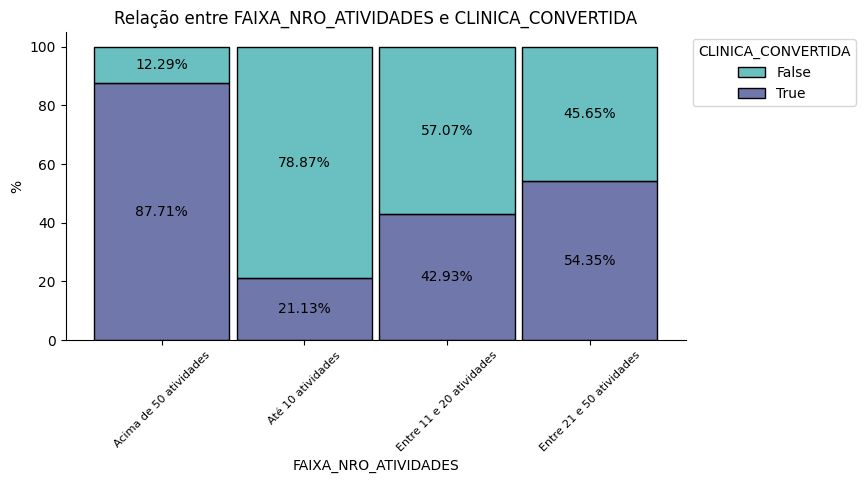

In [433]:
lib.plot_relacao_entre_2cat(df_real.loc[df_real['IS_VALID_ACTIVITY']], coluna1='FAIXA_NRO_ATIVIDADES', coluna2='CLINICA_CONVERTIDA')

In [299]:
# Clinicas que tiveram somente atividades invalidas, porem foram convertidas.
tabela = pd.crosstab(df_real['CLINIC_ID'], df_real['IS_VALID_ACTIVITY']).reset_index()
somente_atividades_invalidas = tabela.loc[tabela[True] == 0]['CLINIC_ID']
df_real.loc[(df_real['CLINIC_ID'].isin(somente_atividades_invalidas)) & (df_real['CLINICA_CONVERTIDA'])].drop_duplicates(subset=['CLINIC_ID']).shape

(53, 28)

In [300]:
# Clinicas que tiveram somente atividades invalidas, porem foram convertidas.
df_real.loc[(df_real['CLINIC_ID'].isin(somente_atividades_invalidas)) & (df_real['CLINICA_CONVERTIDA'])].drop_duplicates(subset=['CLINIC_ID']).head()

,CLINIC_ID,ACTIVITY_AT,ACTIVITY_TYPE,FEATURE,MODULE,IS_VALID_ACTIVITY,CLINIC_CREATED_AT,IS_CHAIN_CLINIC,FIRST_USER_HUBSPOT_SOURCE,INTEREST_CATEGORY_SIGNUP,...,CLINIC_ACCREDITATION_STATUS,STRIPE_SUBSCRIPTION_ID,SUBSCRIPTION_START_DATE,SUBSCRIPTION_END_DATE,SUBSCRIPTION_PERIOD_DAYS,SUBSCRIPTION_PERIOD,SUBSCRIPTION_STATUS,BILLING_INTERVAL_IN_MONTHS,CLINICA_CONVERTIDA,FAIXA_NRO_ATIVIDADES
59,9933,2023-08-25 10:04:00.409,pre_analysis,bnpl,finance,False,2023-08-23 12:07:17.826,False,Inbound,Apenas BNPL,...,Concluído,sub_1Nkq5JCpjOdJI4gTFQQbh2Oh,2023-08-30,NaT,999.0,Período em aberto,active,1.0,True,None
94,9940,2023-08-25 11:50:11.634,pre_analysis,bnpl,finance,False,2023-08-23 15:04:20.665,False,Inbound,Apenas BNPL,...,Concluído,sub_1NqcOJCpjOdJI4gTxoRWE20N,2023-09-15,NaT,999.0,Período em aberto,active,6.0,True,None
213,9948,2023-08-25 17:07:50.377,pre_analysis,bnpl,finance,False,2023-08-23 17:09:54.743,False,Inbound,Apenas BNPL,...,Concluído,sub_1Nv3NHCpjOdJI4gT8Fp8v9oG,2023-09-27,NaT,999.0,Período em aberto,active,1.0,True,None
523,9935,2023-08-28 14:53:52.307,pre_analysis,bnpl,finance,False,2023-08-23 13:16:41.598,False,Inbound,Apenas BNPL,...,Concluído,sub_1NlYTSCpjOdJI4gTiZRbOo5T,2023-09-01,2023-11-01,61.0,Entre 61 e 90 dias,active,1.0,True,None
615,9766,2023-08-28 19:37:45.760,pre_analysis,bnpl,finance,False,2023-08-18 19:02:19.079,False,Inbound,Apenas BNPL,...,Concluído,sub_1Npt5NCpjOdJI4gTA3YVFnlF,2023-09-13,NaT,999.0,Período em aberto,active,6.0,True,None


In [583]:
# Identificação de atividades que têm maior correlação com a conversão (e.g., clínicas que usam a gestão financeira têm maior chance de converter).
df_real.loc[(df_real['IS_VALID_ACTIVITY'] == True) & 
            (df_real['CLINIC_ID'].isin(clinicas_convertidas))][['FEATURE', 'CLINIC_ID']].groupby(by='FEATURE')['CLINIC_ID'].nunique().sort_values()

FEATURE
payment_book             2
bnpl                     6
credit_check            18
documents_and_files     33
patient_management      53
revenue_management      58
user_management         63
anamnese                87
budget_management       91
medical_record         117
scheduling             180
Name: CLINIC_ID, dtype: int64

In [437]:
# Identificação de atividades que têm maior correlação com a conversão (e.g., clínicas que usam a gestão financeira têm maior chance de converter).
lib.grpby_2cat(dataframe=df_real.loc[(df_real['IS_VALID_ACTIVITY'])].drop_duplicates(subset=['FEATURE','CLINIC_ID']), coluna1='FEATURE', coluna2='CLINICA_CONVERTIDA')

,FEATURE,CLINICA_CONVERTIDA,frequencia,porcentagem
0,anamnese,False,196,69.257951
1,anamnese,True,87,30.742049
3,bnpl,False,1,14.285714
2,bnpl,True,6,85.714286
4,budget_management,False,203,69.047619
5,budget_management,True,91,30.952381
7,credit_check,False,12,40.000000
6,credit_check,True,18,60.000000
8,documents_and_files,False,82,71.304348
9,documents_and_files,True,33,28.695652


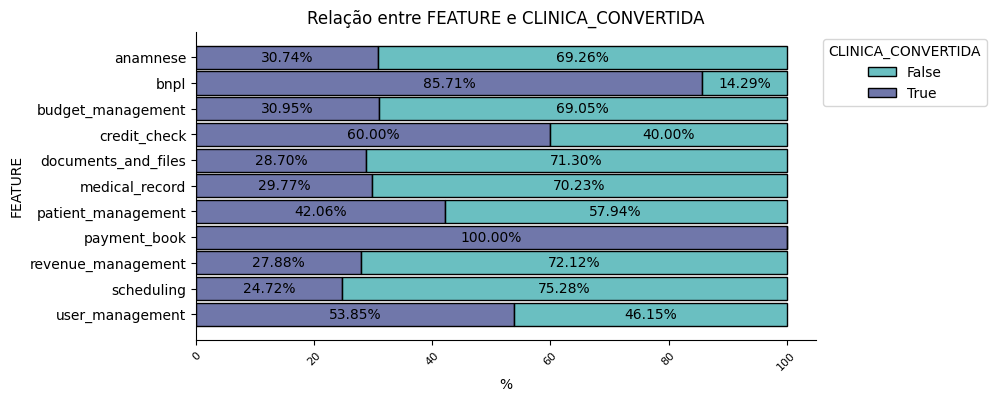

In [443]:
lib.plot_relacao_entre_2cat(dataframe=df_real.loc[(df_real['IS_VALID_ACTIVITY'])].drop_duplicates(subset=['FEATURE','CLINIC_ID']), coluna1='FEATURE', coluna2='CLINICA_CONVERTIDA', orient='h')

In [284]:
# Média da quantidade de atividades válidas de clínicas convertidas
atividades_validas_clinicas_convertidas = df_real.loc[(df_real['IS_VALID_ACTIVITY']) & (df_real['CLINICA_CONVERTIDA'])].groupby(by='CLINIC_ID')['IS_VALID_ACTIVITY'].count()
atividades_validas_clinicas_convertidas.mean()

21.557603686635943

In [285]:
# Média da quantidade de atividades válidas de clínicas não convertidas
atividades_validas_clinicas_nao_convertidas = df_real.loc[(df_real['IS_VALID_ACTIVITY']) & (~df_real['CLINICA_CONVERTIDA'])].groupby(by='CLINIC_ID')['IS_VALID_ACTIVITY'].count()
atividades_validas_clinicas_nao_convertidas.mean()

5.503912363067292

In [311]:
# Criando a coluna TRIAL_DURATION_INTERVAL para categorizar o TRIAL_DURATION em (Até 7 dias) ou (Acima de 7 dias).
df_real['TRIAL_DURATION_INTERVAL'] = pd.cut(df_real['TRIAL_DURATION'], bins=[0,7,14,365], labels=['Até 7 dias', 'Entre 8 e 14 dias', 'Acima de 14 dias'], include_lowest=True)

In [444]:
# Identificação do intervalo de período de Trial que têm maior correlação com a conversão.
lib.grpby_2cat(dataframe=df_real.drop_duplicates(subset=['CLINIC_ID']), coluna1='TRIAL_DURATION_INTERVAL', coluna2='CLINICA_CONVERTIDA')

,TRIAL_DURATION_INTERVAL,CLINICA_CONVERTIDA,frequencia,porcentagem
0,Até 7 dias,False,653,73.785311
1,Até 7 dias,True,232,26.214689
2,Entre 8 e 14 dias,False,24,54.545455
3,Entre 8 e 14 dias,True,20,45.454545
4,Acima de 14 dias,False,36,66.666667
5,Acima de 14 dias,True,18,33.333333


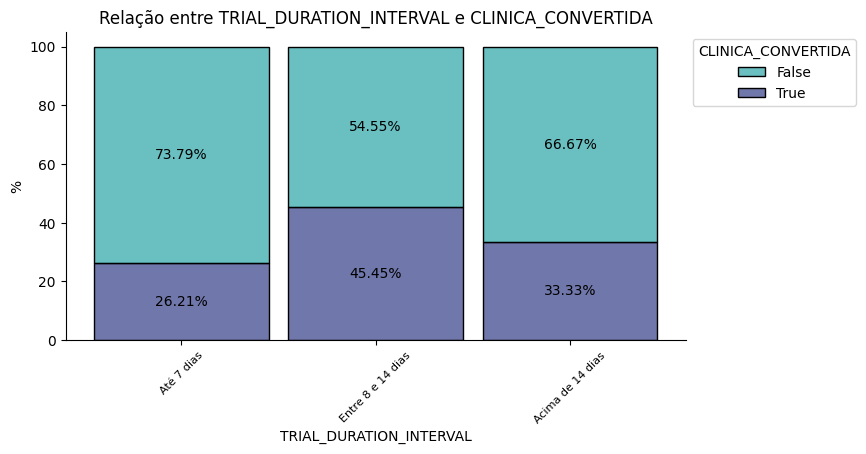

In [445]:
lib.plot_relacao_entre_2cat(dataframe=df_real.drop_duplicates(subset=['CLINIC_ID']), coluna1='TRIAL_DURATION_INTERVAL', coluna2='CLINICA_CONVERTIDA')

In [447]:
#  Percentual de comparação de performance de conversão entre diferentes fontes de canal de marketing.
lib.grpby_2cat(dataframe=df_real.drop_duplicates(subset=['CLINIC_ID']), coluna1='MARKETING_ATTRIBUITION_CHANNEL_GROUP', coluna2='CLINICA_CONVERTIDA')

,MARKETING_ATTRIBUITION_CHANNEL_GROUP,CLINICA_CONVERTIDA,frequencia,porcentagem
0,Organic,False,39,58.208955
1,Organic,True,28,41.791045
2,Other,False,161,71.875000
3,Other,True,63,28.125000
4,Paid - google,False,271,74.655647
5,Paid - google,True,92,25.344353
6,Paid - meta,False,220,78.014184
7,Paid - meta,True,62,21.985816
9,Site ou Indicação Interna,False,22,46.808511
8,Site ou Indicação Interna,True,25,53.191489


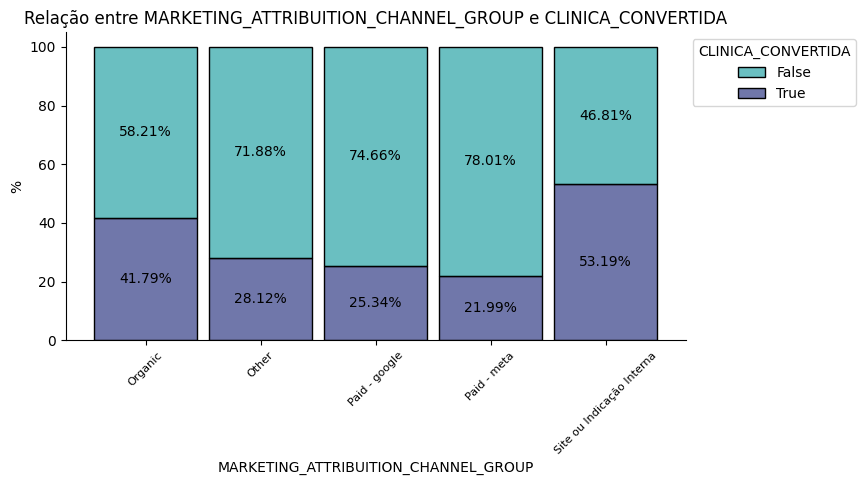

In [448]:
lib.plot_relacao_entre_2cat(dataframe=df_real.drop_duplicates(subset=['CLINIC_ID']), coluna1='MARKETING_ATTRIBUITION_CHANNEL_GROUP', coluna2='CLINICA_CONVERTIDA')

In [115]:
conversion_counts = clinicas_unicas_periodo_trial.groupby('MARKETING_ATTRIBUITION_CHANNEL_GROUP')['CLINIC_ID'].apply(
    lambda x: pd.Series([x.isin(clinicas_convertidas).sum(), (~x.isin(clinicas_convertidas)).sum()])
).unstack()
conversion_counts

,0,1
MARKETING_ATTRIBUITION_CHANNEL_GROUP,,
Organic,28,39
Other,63,161
Paid - google,92,271
Paid - meta,62,220
Site ou Indicação Interna,25,22


In [120]:
conversion_rate_by_marketing_channel = clinicas_unicas_periodo_trial.groupby('MARKETING_ATTRIBUITION_CHANNEL_GROUP')['CLINIC_ID'].apply(
    lambda x: x.isin(clinicas_convertidas).mean() * 100
)
conversion_rate_by_marketing_channel

MARKETING_ATTRIBUITION_CHANNEL_GROUP
Organic                      41.791045
Other                        28.125000
Paid - google                25.344353
Paid - meta                  21.985816
Site ou Indicação Interna    53.191489
Name: CLINIC_ID, dtype: float64

* #### Métricas de Credenciamento no Trial

In [449]:
# Percentual de clínicas que solicitaram credenciamento durante o trial.
clinicas_unicas_periodo_trial.loc[clinicas_unicas_periodo_trial['HAS_ASKED_FOR_ACCREDITATION']]['CLINIC_ID'].agg({'frequência':'count'
                                                                                                                          ,'percentual': lambda x: (x.count() / clinicas_unicas_periodo_trial.shape[0]) * 100})

frequência    349.000000
percentual     35.503561
Name: CLINIC_ID, dtype: float64

In [450]:
# Conversão de clínicas credenciadas versus não credenciadas.  
lib.grpby_2cat(dataframe=df_real.drop_duplicates(subset=['CLINIC_ID']), coluna1='IS_ACCREDITATION_APPROVED', coluna2='CLINICA_CONVERTIDA')

,IS_ACCREDITATION_APPROVED,CLINICA_CONVERTIDA,frequencia,porcentagem
0,False,False,621,88.587732
1,False,True,80,11.412268
3,True,False,92,32.624113
2,True,True,190,67.375887


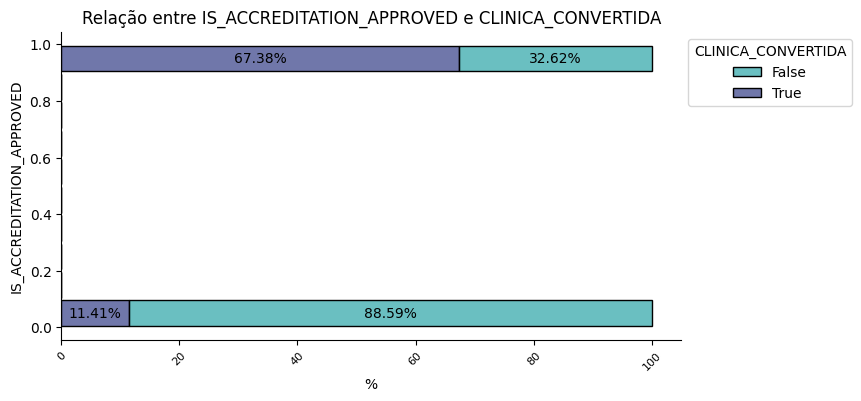

In [452]:
lib.plot_relacao_entre_2cat(dataframe=df_real.drop_duplicates(subset=['CLINIC_ID']), coluna1='IS_ACCREDITATION_APPROVED', coluna2='CLINICA_CONVERTIDA', orient='h')

>    * De um total de 282 clínicas credenciadas, 190 (67.38%) foram convertidas e 92 (32.62%) não foram convertidas.
>    * De um total de 701 clínicas não credenciadas, 80 (11.41%) foram convertidas e 621 (88.59%) não foram convertidas.

* #### Métricas de Desempenho do Trial

In [453]:
# Percentual de clínicas que param de usar o produto durante o trial (não realizaram a assinatura do produto - não foram convertidas).  
num_churn_clinicas_durante_trial = df_real.loc[~df_real['CLINICA_CONVERTIDA']]['CLINIC_ID'].nunique()
perc_churn_clinicas_durante_trial = (num_churn_clinicas_durante_trial / clinicas_unicas_periodo_trial.shape[0]) * 100
print(f'De um total de {clinicas_unicas_periodo_trial.shape[0]} clínicas cadastradas no período Trial, {num_churn_clinicas_durante_trial} ({perc_churn_clinicas_durante_trial:.2f}%) pararam de usar o produto durante o trial.')

De um total de 983 clínicas cadastradas no período Trial, 713 (72.53%) pararam de usar o produto durante o trial.


In [454]:
# Percentual de clínicas que param de usar o produto após o trial (realizaram a assinatura do produto, porem não esta mais ativa).  
num_churn_clinicas_apos_trial = df_real.loc[(df_real['CLINICA_CONVERTIDA']) & (df_real['SUBSCRIPTION_STATUS'] != 'active')]['CLINIC_ID'].nunique()
perc_churn_clinicas_apos_trial = (num_churn_clinicas_apos_trial / clinicas_unicas_periodo_trial.shape[0]) * 100
print(f'De um total de {clinicas_unicas_periodo_trial.shape[0]} clínicas cadastradas no período Trial, {num_churn_clinicas_apos_trial} ({perc_churn_clinicas_apos_trial:.2f}%) pararam de usar o produto após o trial.')


De um total de 983 clínicas cadastradas no período Trial, 29 (2.95%) pararam de usar o produto após o trial.


#### Vamos analisar os resultados das métricas:

* Distribuição da duração do período de trial para todas as clínicas.
    * A média de duração do período de trial foi de aproximadamente 8.61 dias.
    * 75% das clínicas tiveram seu período de trial de até 7 dias.

* Distribuição do número de atividades válidas por clínica durante o trial.
    * A média de atividades realizadas por clínica durante o trial foi de 9.573.
    * Aproximadamente 75% (642) das clínicas realizaram até 8 atividades durante o período trial.
    * O maior número de atividades registradas foi de 599.

* Quais funcionalidades são mais usadas durante o trial.
    * medical_record - frequência:  2773 - 33.83%
    * scheduling - frequência: 2460 - 30.00%
    * budget_management - frequência: 949 - 11.58%

* Percentual de clínicas que utilizam funcionalidades específicas.
    * payment_book : 0.086%
    * bnpl : 0.304%
    * credit_check : 1.304%
    * documents_and_files : 5.002%
    * user_management : 5.089%
    * patient_management : 5.480%
    * revenue_management : 9.047%
    * anamnese : 12.309%
    * budget_management : 12.788%
    * medical_record : 17.094%
    * scheduling : 31.491%

* Percentual de clínicas que convertem para assinaturas pagas após o trial. 
    *   Aproximadamente 27.46% das clínicas cadastradas.

* Tempo médio desde o início do trial até a conversão para assinatura paga.
    * A média de tempo foi de aproximadamente 9.31 dias.
    * Aproximadamente 75% das clínicas converteram em no máximo 12 dias.
    * O número máximo de dias para conversão foi de 60 dias.
     
* Comparação de conversão entre clínicas que realizaram um número alto de atividades válidas versus um número baixo.
    * A maior proporção de clínicas convertidas (88%) foram aquelas que realizaram acima de 50 atividades válidas.
    * A menor proporção de clínicas convertidas (22%) foram aquelas que realizaram até 10 atividades válidas.


* Identificação de atividades específicas que têm maior correlação com a conversão para assinaturas pagas.    
    * user_management: 53.846%
    * bnpl : 85.714%
    * credit_check : 60.00%

* Média da quantidade de atividades válidas de clínicas convertidas.
    * A média foi de aproximadamente 21.55 atividades.

* Média da quantidade de atividades válidas de clínicas não convertidas.
    * A média foi de aproximadamente 5.50 atividades.

* Identificação do intervalo de período de Trial que têm maior correlação com a conversão.
    * A maior proporção de clínicas convertidas (45.45%), tiveram seu período de Trial entre 8 e 14 dias.

* Percentual de comparação de performance de conversão entre diferentes fontes de canal de marketing.
    * Paid - google	: 25.344%
    * Other	: 28.125%
    * Paid - meta :	21.985%
    * Organic :	41.791%
    * Site ou Indicação Interna	: 53.191%

* Percentual de clínicas que solicitaram credenciamento durante o trial.
    * Aproximadamente 35.50% das clínicas cadastradas.

* Conversão de clínicas credenciadas versus não credenciadas.
    * De um total de 282 clínicas credenciadas, 190 (67.38%) foram convertidas e 92 (32.62%) não foram convertidas.
    * De um total de 701 clínicas não credenciadas, 80 (11.41%) foram convertidas e 621 (88.59%) não foram convertidas.

* Percentual de clínicas que param de usar o produto durante o trial (não realizaram a assinatura do produto). 
    * De um total de 983 clínicas cadastradas no período Trial, 713 (72.53%) pararam de usar o produto durante o trial.

* Percentual de clínicas que param de usar o produto após o trial (realizaram a assinatura do produto, porem não esta mais ativa).      
    * De um total de 983 clínicas cadastradas no período Trial, 29 (2.95%) pararam de usar o produto após o trial.